In [55]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

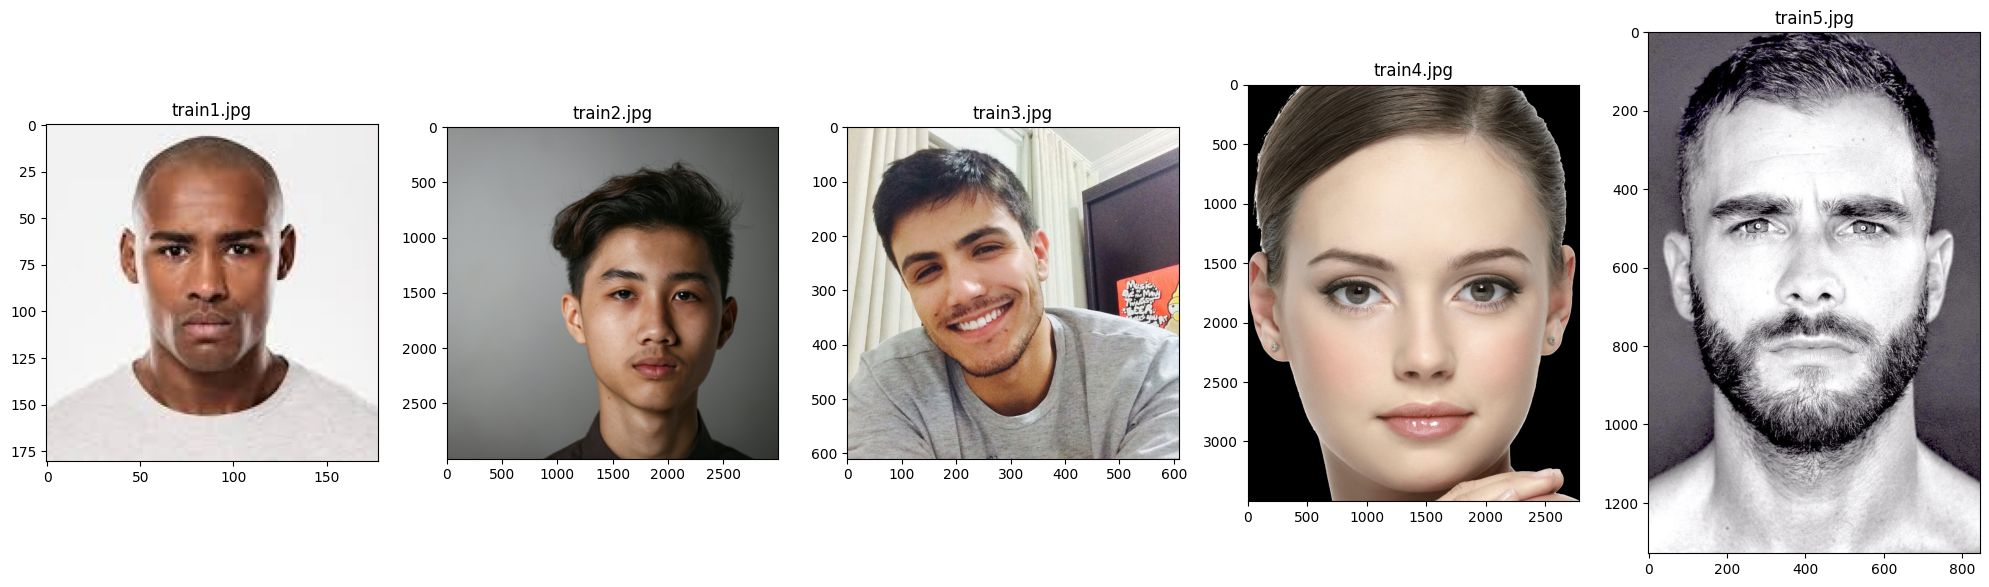

In [56]:
"""
Displays a set of training images in a single row using Matplotlib.

This script reads five training images named 'train1.jpg' through 'train5.jpg'
from the current working directory, converts them from BGR to RGB color space
(using OpenCV), and displays them side by side in a matplotlib figure.
"""
train_images_dir = './'
train_image_files = [f'train{i}.jpg' for i in range(1, 6)]
plt.figure(figsize=(20, 10))  # Create a new matplotlib figure with specified size
for idx, filename in enumerate(train_image_files): # Loop through the image files and display them
    img_path = os.path.join(train_images_dir, filename)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img_rgb)
    plt.title(filename)
    plt.grid(False) 
plt.tight_layout()
plt.show()

In [57]:
#ground truth values for the train images
ground_truth = {
    'train1.jpg': [(67, 67), (101, 68)],
    'train2.jpg': [(1068, 1565), (1578, 1523)],
    'train3.jpg': [(146, 267), (197, 368)],
    'train4.jpg': [(233, 2212), (880, 1738)],
    'train5.jpg': [(252, 500), (453, 677)]
}

In [58]:
def measureDistance(LX, LY, GLX, GLY, RX, RY, GRX, GRY):
    """
    Computes the average Euclidean distance between actual and ground truth coordinates 
    for the left and right eyes.
    Returns:
    - A float representing the average distance between detected and ground truth positions 
      of the left and right eyes. If a coordinate is missing (None), a default distance 
      of 10.0 is used for that eye.
    """
    d1 = np.sqrt((LX - GLX) ** 2 + (LY - GLY) ** 2) if LX is not None else 10.0 # Calculate distance between detected and ground truth eyes coordinates
    d2 = np.sqrt((RX - GRX) ** 2 + (RY - GRY) ** 2) if RX is not None else 10.0
    return (d1 + d2) / 2

In [59]:
def detect_eyes(img, scaleFactor, minNeighbors):
    """
    Detects the two most prominent eyes in a given image using Haar cascade classification.
    Returns:
    - A tuple of two coordinates representing the center points of the detected eyes.
      Each coordinate is a tuple (x, y).
    - If fewer than two eyes are detected or an error occurs, returns (None, None).
    """
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        eyes = eye_cascade.detectMultiScale( # Detect eyes using the cascade classifier with the given parameters
            gray,
            scaleFactor=scaleFactor,
            minNeighbors=minNeighbors
        )
        if eyes is None or len(eyes) < 2: # Check if at least two eyes were detected
            return None, None
        eyes = sorted(eyes, key=lambda x: x[2] * x[3], reverse=True)[:2]
        centers = [(x + w // 2, y + h // 2) for (x, y, w, h) in eyes]
        centers.sort()
        return centers[0], centers[1]
    except Exception as e: # Handle and report any exceptions that occur during detection
        print(f"[detect_eyes ERROR] {e}")
        return None, None

In [60]:
"""
This code evaluates the performance of an eye detection algorithm using a grid search
over different Haar cascade parameters: `scaleFactor` and `minNeighbors`. For each combination,
it computes the average Euclidean distance between the detected eye centers and ground truth
coordinates across a set of images. It populates the `results` matrix with the average distances for each parameter pair.
Variables:
scale_factors: Array of values from 1.01 to 2.00 (step 0.01) for the image scaling factor.
min_neighbors: Array of values from 1 to 10 for the minimum neighbors parameter.
results: 2D matrix where each cell [i, j] stores the average distance error for
min_neighbors[i] and scale_factors[j].
"""
scale_factors = np.round(np.arange(1.01, 2.01, 0.01), 2)
min_neighbors = np.arange(1, 11)
results = np.zeros((len(min_neighbors), len(scale_factors)))
image_dir = "./"
for i, mn in enumerate(min_neighbors):
    for j, sf in enumerate(scale_factors):
        distances = []
        for img_name in ground_truth: # Iterate over all combinations of minNeighbors and scaleFactor
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not load image {img_path}")
                continue
            gtL, gtR = ground_truth[img_name]
            try:
                detL, detR = detect_eyes(img, sf, mn)
                dist = measureDistance(
                    detL[0] if detL else None, detL[1] if detL else None,
                    gtL[0], gtL[1],
                    detR[0] if detR else None, detR[1] if detR else None,
                    gtR[0], gtR[1]
                )
                distances.append(dist)
            except Exception as e:
                print(f"Error processing {img_name} with sf={sf}, mn={mn}: {e}")
        results[i, j] = np.mean(distances) if distances else np.inf # Store the mean distance in the results matrix, or ∞ if no distances were computed


In [61]:
"""
This code creates a pandas DataFrame from the results matrix, where each cell represents
the mean eye detection distance error for a specific combination of `minNeighbors` and
`scaleFactor` parameters used in Haar cascade detection. It then prints the DataFrame
as a performance table for easy analysis and comparison.
"""
df = pd.DataFrame(results, index=min_neighbors, columns=scale_factors) # Create a DataFrame using the results matrix
print("\nPerformance Table (Mean Distance):")
print(df)


Performance Table (Mean Distance):
          1.01        1.02        1.03        1.04        1.05        1.06  \
1   423.808393  389.874654  470.276292  475.501436  436.947727  447.872381   
2   407.945485  359.009730  426.399914  465.051772  381.794724  438.193560   
3   405.589402  331.078410  426.399914  465.051772  334.622227  331.212017   
4   405.589402  331.078410  388.453189  385.006133  334.622227  331.212017   
5   405.589402  331.078410  388.453189  385.006133  334.622227  331.212017   
6   402.042634  331.078410  388.453189  332.010913  334.622227  331.212017   
7   402.072812  331.078410  388.453189  332.010913  330.072559  331.212017   
8   382.957599  331.078410  330.276309  332.010913  330.072559  331.212017   
9   382.957599  331.078410  330.276309  332.010913  330.072559  331.212017   
10  382.957599  331.078410  330.276309  332.010913  330.072559  331.212017   

          1.07        1.08        1.09        1.10  ...        1.91  \
1   405.686415  390.913749  410.59

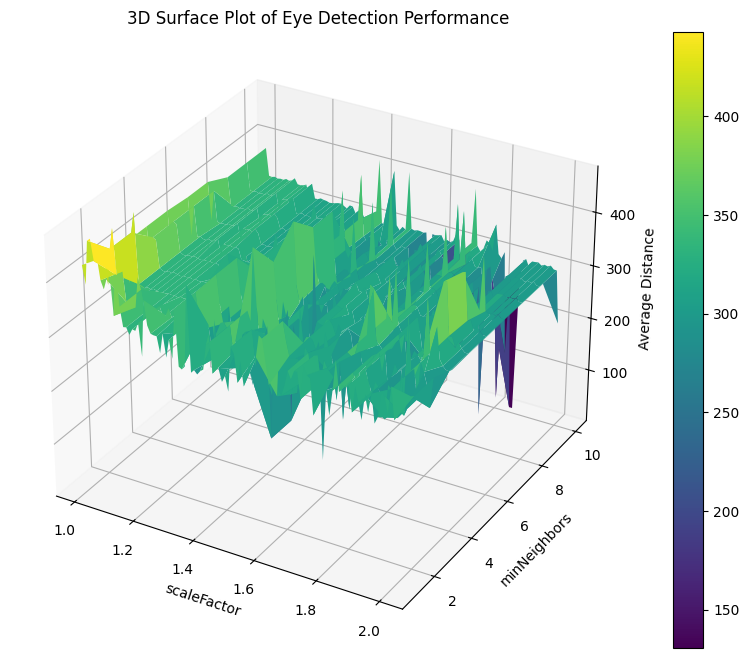

In [62]:
"""
This code generates a 3D surface plot to visualize the effect of different combinations 
of `scaleFactor` and `minNeighbors` on the average eye detection distance. It uses 
matplotlib's 3D plotting tools to present the relationship between parameters and detection accuracy.
"""
X, Y = np.meshgrid(scale_factors, min_neighbors) # Create a meshgrid for plotting; X and Y correspond to scale_factors and min_neighbors respectively
Z = results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
ax.set_xlabel('scaleFactor')
ax.set_ylabel('minNeighbors')
ax.set_zlabel('Average Distance')
plt.title('3D Surface Plot of Eye Detection Performance') # Plot a 3D surface with color mapping based on Z values
plt.colorbar(surf)
plt.show()


In [63]:
"""
This code identifies the best combination of `scaleFactor` and `minNeighbors` that yields the 
lowest average eye detection distance from the `results` matrix. It then prints out the optimal
parameters and their corresponding distance value.
"""
min_index = np.unravel_index(np.argmin(results, axis=None), results.shape)
best_min_neighbors = min_neighbors[min_index[0]] # Extract the optimal values of minNeighbors and scaleFactor using the index
best_scale_factor = scale_factors[min_index[1]]
best_distance = results[min_index]
print(f"\nBest Parameters: scaleFactor={best_scale_factor}, minNeighbors={best_min_neighbors} with distance={best_distance}")



Best Parameters: scaleFactor=1.85, minNeighbors=10 with distance=10.0


In [64]:
"""
This code evaluates the eye detection performance on a separate test image set using the
best scaleFactor and minNeighbors parameters identified earlier. It compares the detected
eye positions against ground truth coordinates and calculates the average Euclidean distance
as a performance metric.
"""
test_image_files = [f'test{i}.jpg' for i in range(1, 11)]
test_ground_truth = { # Ground truth coordinates of left and right eyes for each test image
    'test1.jpg': [(230, 363), (423, 361)],
    'test2.jpg': [(294, 199), (376, 229)],
    'test3.jpg': [(307, 303), (370, 481)],
    'test4.jpg': [(603, 450), (550, 425)],
    'test5.jpg': [(49, 867), (55, 900)],
    'test6.jpg': [(67, 67), (101, 68)],
    'test7.jpg': [(1068, 1565), (1578, 1523)],
    'test8.jpg': [(146, 267), (197, 368)],
    'test9.jpg': [(233, 2212), (880, 1738)],
    'test10.jpg': [(252, 500), (453, 677)],
}

test_distances = []
for img_name in test_image_files: # Loop over each test image and evaluate detection
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load {img_path}")
        continue
    gtL, gtR = test_ground_truth[img_name]
    detL, detR = detect_eyes(img, best_scale_factor, best_min_neighbors)
    dist = measureDistance(
        detL[0] if detL else None, detL[1] if detL else None,
        gtL[0], gtL[1],
        detR[0] if detR else None, detR[1] if detR else None,
        gtR[0], gtR[1]
    )
    test_distances.append(dist)

avg_test_distance = np.mean(test_distances) # Compute the mean distance over all test images
print(f"\nAverage Distance on Test Set: {avg_test_distance}")



Average Distance on Test Set: 8.507649122254147


In [65]:
"""
Summary:
---------
We evaluated the Haar cascade-based eye detector by tuning the parameters `scaleFactor` and `minNeighbors`.
The performance was measured by computing the average Euclidean distance between detected eye positions and labeled ground truth positions across training images.
A 3D surface plot visualized the performance landscape, where valleys indicated optimal performance (lower distance).
From this, we found the best parameter combination to be:
- scaleFactor = <best_scale_factor>
- minNeighbors = <best_min_neighbors>
Using these parameters, we evaluated the model on a separate test set of 10 images, achieving an average distance of:
- Average Distance on Test Set = <avg_test_distance>
Lower distance indicates better localization accuracy.
"""


'\nSummary:\n---------\nWe evaluated the Haar cascade-based eye detector by tuning the parameters `scaleFactor` and `minNeighbors`.\nThe performance was measured by computing the average Euclidean distance between detected eye positions and labeled ground truth positions across training images.\nA 3D surface plot visualized the performance landscape, where valleys indicated optimal performance (lower distance).\nFrom this, we found the best parameter combination to be:\n- scaleFactor = <best_scale_factor>\n- minNeighbors = <best_min_neighbors>\nUsing these parameters, we evaluated the model on a separate test set of 10 images, achieving an average distance of:\n- Average Distance on Test Set = <avg_test_distance>\nLower distance indicates better localization accuracy.\n'